In [1]:
import json

In [2]:
# Opening JSON file
f = open('GIS_all.json')
 
# returns JSON object as
# a dictionary
data = json.load(f)

## Filter Out 911

In [11]:
data_911 = []
data_else = []

for d in data:
    if len(d["reason"]) <= len("Borough of Staten Island") or "September 11, 2001" in d["reason"]:
        data_911.append(d)
    else:
        data_else.append(d)
        

In [12]:
len(data_911)

497

In [13]:
with open("data_911.json", "w") as outfile:
    json.dump(data_911, outfile)

In [14]:
with open("data_except_911.json", "w") as outfile:
    json.dump(data_else, outfile)

## Clustering 

In [333]:
##source code: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [15]:
import torch
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')



In [23]:
import pandas as pd 

In [212]:
# eliminate = ["Hayes", "Section", "repeals", "Stavisky", ""]

In [213]:
reason_list = []
for d in data_else:
    
    reason = d["reason"][:1000]
    
#     for term in eliminate:
#         reason = reason.replace(term, "");
        
    reason_list.append(reason)
    
len(reason_list)

2014

In [214]:
embeddings = model.encode(reason_list, show_progress_bar=True)

In [233]:
# import umap
umap_embeddings = umap.UMAP(n_neighbors=7, 
                            n_components=4, 
                            metric='cosine').fit_transform(embeddings)

In [234]:
# import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=7,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

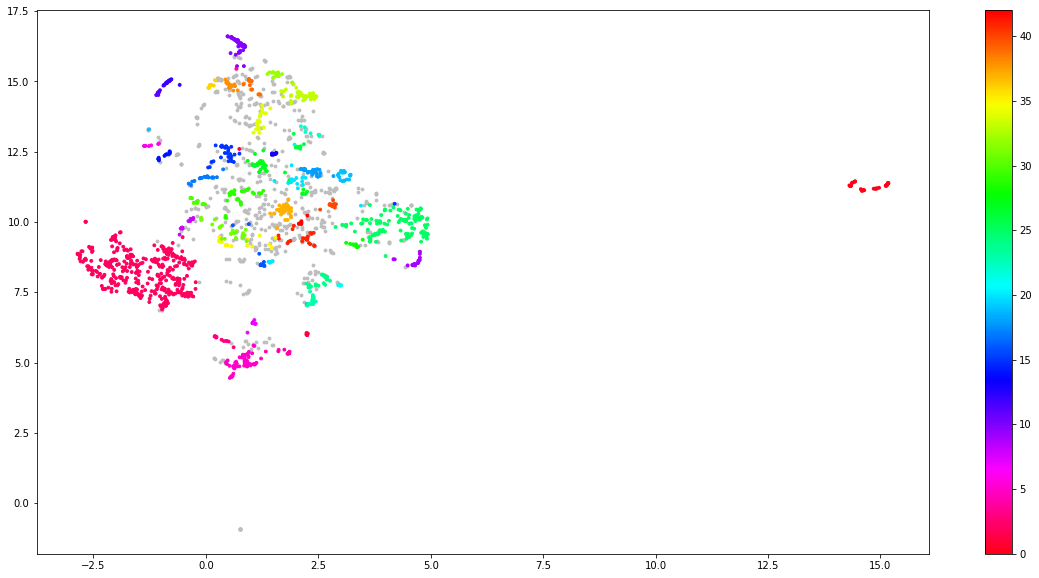

In [235]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=7, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=8)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=8, cmap='hsv_r')
plt.colorbar()

### Topic generation

In [236]:

docs_df = pd.DataFrame(data_else, columns=["reason"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'reason': ' '.join})

In [237]:

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.reason.values, m=len(data_else))

In [238]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .reason
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "reason": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,605
3,2,397
26,25,138
6,5,72
11,10,52
34,33,49
38,37,46
1,0,38
28,27,35
16,15,31


In [221]:
from wordcloud import WordCloud

def draw_word_cloud(num):
    
    aa = pd.DataFrame(top_n_words[num], columns=['word', 'freq'])
    aa.index = aa.word
    bb = aa.drop(columns=['word'])
    bb['freq'].astype(float)

    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(bb['freq'])
    plt.imshow(wordcloud)
    plt.savefig('img'+str(num)+'.png')

### topic reduction

In [222]:
import sklearn

In [357]:
for i in range(20):
    # Calculate cosine similarity
    similarities = sklearn.metrics.pairwise.cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("reason", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'reason': ' '.join})

    # Calculate new topic words
    m = len(data_else)
    tf_idf, count = c_tf_idf(docs_per_topic.reason.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; ge

,Topic,Size
0,-1,1245
1,0,519
3,2,138
2,1,112


In [358]:
top_n_words

{-1: [('police', 0.004814807364196853),
  ('american', 0.004617856252495022),
  ('island', 0.004560392228575521),
  ('states', 0.004560252545261176),
  ('street', 0.0045088669040782665),
  ('united', 0.004439432317571169),
  ('year', 0.004421119823624059),
  ('officer', 0.004406003164575239),
  ('staten', 0.004296927612410595),
  ('later', 0.004269907884421079),
  ('mr', 0.004259038833081577),
  ('award', 0.004228774876730922),
  ('war', 0.004124891303262009),
  ('president', 0.004060576933073595),
  ('world', 0.004050210570038921),
  ('family', 0.004045485331510314),
  ('bronx', 0.004024516612337296),
  ('city', 0.004007425873580021),
  ('brooklyn', 0.003991037944276764),
  ('avenue', 0.003938076797391273)],
 0: [('women', 0.007931096226250494),
  ('council', 0.0067535644443949645),
  ('health', 0.006749848634107019),
  ('board', 0.006496227514508957),
  ('education', 0.006397179967274408),
  ('center', 0.006103596682886074),
  ('worked', 0.006076764335975022),
  ('program', 0.0060669

In [362]:
new_groupList = [
    [''],
    ['music', 'jazz', 'band', 'album', 'latin', 'singer', 'art', 'arts' ,'culture', 'cultural', 'musicians', 'cuba'],
    ['tuskegee','Airmen', 'squadron', 'fighter', 'aircraft', '1943', 'pilot', 'world war II', 'Iraq', 'korean',
     'war', 'army', 'infantry', 'killed', 'combat', 'medal', 'bronze', 'duty'],
    ['women', 'Ms', 'education', 'children', 'worked', 'council', 'health', 'board', 'hospital', 'public', 'school','committee','rights'],
    ['customers', 'family', 'business', 'immigrants', 'immigration', 'community'],
    ['legal', 'senate', 'court', 'civic', 'governor', 'appointed', 'elected'],
    ["baptist", 'church', 'pastor', 'reverend', 'bishop','ministry', 'churches', 'bible', 'god', 'congregation'],
    ['health', 'Nos Quedamos(WE STAY)', 'UHP', 'primary care', 'gay rights', 'development', 'activists', 'hospitals', 'HIV', 'AIDS'],
]


In [83]:
docs_df["Topic"]

0        2
1        2
2       10
3        8
4       -1
        ..
2009    18
2010    10
2011    -1
2012    16
2013    -1
Name: Topic, Length: 2014, dtype: int64

In [193]:
# groupList = [-1,2,5,13,1,12,16,18,4,10]

groupList = [-1,2,5,9,1,3,16,0,14,10]

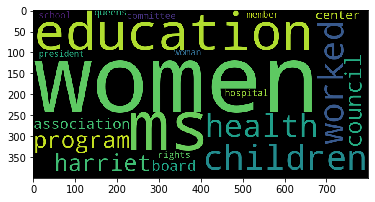

In [194]:
draw_word_cloud(2)

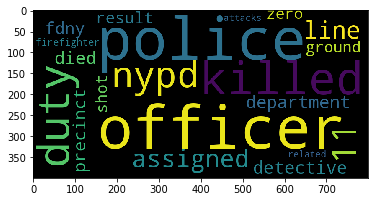

In [195]:
draw_word_cloud(5)

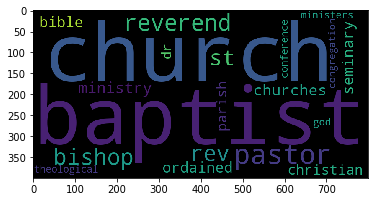

In [196]:
draw_word_cloud(9)

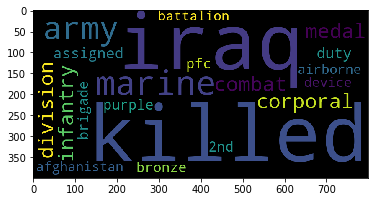

In [198]:
draw_word_cloud(3)

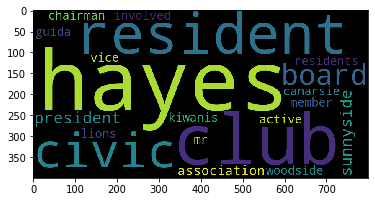

In [199]:
##3,16,0,14,10
draw_word_cloud(16)

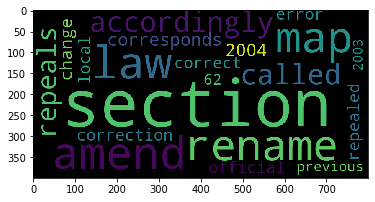

In [200]:
draw_word_cloud(0)

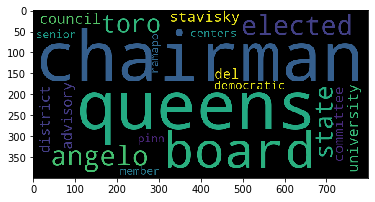

In [201]:
draw_word_cloud(14)

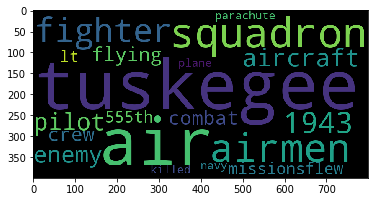

In [202]:
draw_word_cloud(10)

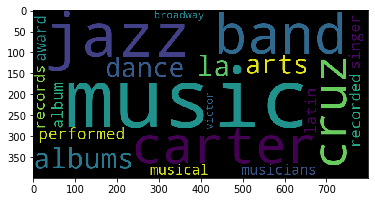

In [203]:
draw_word_cloud(1)

In [204]:
top_n_words

{-1: [('league', 0.005565000720076896),
  ('island', 0.005344094132841158),
  ('staten', 0.005019275322650514),
  ('bronx', 0.004777424871431719),
  ('president', 0.004748205766822773),
  ('american', 0.004734516174488392),
  ('baseball', 0.004632039819005801),
  ('park', 0.0046318400011337605),
  ('united', 0.0045812748108986475),
  ('business', 0.004577281949487743),
  ('war', 0.004541777600389714),
  ('states', 0.004507523784599556),
  ('high', 0.004457713697487027),
  ('people', 0.004418510789264594),
  ('award', 0.004366422522557594),
  ('mr', 0.004201262749493777),
  ('world', 0.004182377944627769),
  ('local', 0.0041557377944140255),
  ('association', 0.004151023873828798),
  ('children', 0.004108869352245763)],
 0: [('section', 0.2897263997061445),
  ('law', 0.11111945596413045),
  ('amend', 0.10809792100891258),
  ('map', 0.10187117207642726),
  ('rename', 0.10187117207642726),
  ('accordingly', 0.09489331716575186),
  ('called', 0.09359419545955011),
  ('repeals', 0.083777097

In [205]:
len(top_n_words)

19

In [206]:
with open("top_n_words.json", "w") as outfile:
    json.dump(top_n_words, outfile)

### saving result

In [207]:
docs_df

,reason,Topic,Doc_ID
0,Harriet Tubman was born Harriet Ross in Dorche...,2,0
1,Harriet Tubman was born Harriet Ross in Dorche...,2,1
2,"Amadou Diallo was born on September 2, 1975 in...",11,2
3,Bobby Bello was born and raised in Bay Ridge. ...,8,3
4,"Jonathan Nigro was born on September 8, 1973 a...",-1,4
...,...,...,...
2009,Daniel Andrews spent his career as a civil ser...,16,2009
2010,Robert Deandre Williams was born in Queens. Hi...,-1,2010
2011,"Born in Puerto Rico, Jose Miranda Sr. knew fro...",-1,2011
2012,"Urban Health Plan, Inc. (UHP) is a federally q...",15,2012


In [208]:
data_else

[{'id': '20020',
  'coname': 'Harriet Tubman Square',
  'location': 'Frederick Douglass Boulevard and West 122nd Street, Manhattan, NY',
  'lat': 40.8082553,
  'long': -73.95256669999999,
  'borough': 'Manhattan',
  'loc_result': 'Frederick Douglass Boulevard and West 122nd Street, Manhattan, NY',
  'postal': '10027',
  'reason': 'Harriet Tubman was born Harriet Ross in Dorchester County, Maryland in 1820. Her parents were from the Ashanti tribe of West Africa, and they worked as slaves on the Brodas plantation. In addition to producing lumber, Edward Brodas raised slaves to rent and sell. Life was difficult on the plantation, and Harriet was hired out as a laborer by the age of 5. Harriet did not like to work indoors, and she was routinely beaten by her masters. By her early teens, Harriet was no longer allowed to work indoors and was hired out as a field hand. She was a hard worker but considered defiant and rebellious. When she was 15 years old, Harriet tried to help a runaway slave

In [240]:
count = 0
# data_group = [];

for i,d in enumerate(data_else):
    data_new = d;
    
    for idx, g in enumerate(groupList): 
    
        if g == docs_df["Topic"][i]:
            data_new["group"] = g;
            count += 1;
#     data_group.append(data_new)        

count   
    

1455

In [210]:
with open("data_group.json", "w") as outfile:
    json.dump(data_group, outfile)

## Keyword List

In [245]:
print(top_n_words)

{-1: [('american', 0.005049649339623347), ('award', 0.00480312569695767), ('street', 0.004646405266042116), ('people', 0.004631496006276069), ('island', 0.0046249682846320975), ('states', 0.0045187495675175875), ('united', 0.004491961179222354), ('officer', 0.004444595208334023), ('police', 0.004380484799183716), ('business', 0.004321822228252354), ('war', 0.004301855657236816), ('staten', 0.004275947383499727), ('year', 0.004238479740431686), ('world', 0.0041963030702364375), ('president', 0.004192382884978536), ('bronx', 0.004157786832458373), ('college', 0.004075082909946036), ('league', 0.004064629545887222), ('association', 0.0040075552626277966), ('neighborhood', 0.003999081137015034)], 0: [('section', 0.2897263997061445), ('law', 0.11111945596413045), ('amend', 0.10809792100891258), ('map', 0.10187117207642726), ('rename', 0.10187117207642726), ('accordingly', 0.09489331716575186), ('called', 0.09359419545955011), ('repeals', 0.08377709721849731), ('corresponds', 0.0837770972184

In [340]:
groupKeys = []
for group in groupList:
    di = dict (top_n_words[group][:10])
    keys = list(di.keys())
    groupKeys.append({
        group: keys        
    })    
    
len(groupKeys)

10

In [339]:
for g in groupKeys:

    keys = g.get(list(g)[0]) 
    print(keys)

['american', 'award', 'street', 'people', 'island', 'states', 'united', 'officer', 'police', 'business']
['music', 'jazz', 'band', 'carter', 'cruz', 'album', 'albums', 'latin', 'singer', 'recorded']
['tuskegee', 'air', 'squadron', 'airmen', 'fighter', 'aircraft', '1943', 'pilot', 'enemy', 'flying']
['italian', 'italy', 'edmond', 'safra', 'soccer', 'joseph', 'brothers', 'customers', 'family', 'business']
['women', 'ms', 'education', 'children', 'worked', 'council', 'harriet', 'program', 'health', 'board']
['anniversary', 'commemorate', '100th', 'naming', 'celebrating', 'kips', 'sign', 'barnard', 'significance', '125th']
['health', 'nq', 'uhp', 'peter', 'melrose', 'regreso', 'primary', 'care', 'gay', 'development']
['section', 'law', 'amend', 'map', 'rename', 'accordingly', 'called', 'repeals', 'corresponds', '2004']
['war', 'greenpoint', 'pier', 'korean', 'ruby', 'legion', 'island', 'coney', 'sangiorgio', 'army']
['league', 'jonathan', 'science', 'chema', 'charities', '52', 'catholic', 

In [256]:
with open("group_keys.json", "w") as outfile:
    json.dump(groupKeys, outfile)

In [257]:
groupInfo = []

for group in groupList:
    di = dict (top_n_words[group][:10])
    keys = list(di.keys())
    groupInfo.append({
        group: di       
    }) 
groupInfo

[{-1: {'american': 0.005049649339623347,
   'award': 0.00480312569695767,
   'street': 0.004646405266042116,
   'people': 0.004631496006276069,
   'island': 0.0046249682846320975,
   'states': 0.0045187495675175875,
   'united': 0.004491961179222354,
   'officer': 0.004444595208334023,
   'police': 0.004380484799183716,
   'business': 0.004321822228252354}},
 {2: {'music': 0.025748331948289162,
   'jazz': 0.0206446058307041,
   'band': 0.018164695817283198,
   'carter': 0.016381698252669514,
   'cruz': 0.013772346005281178,
   'album': 0.01236577550801123,
   'albums': 0.012092105741460765,
   'latin': 0.011546670700644543,
   'singer': 0.010502306405544708,
   'recorded': 0.010440471091258983}},
 {5: {'tuskegee': 0.03435087456179403,
   'air': 0.031891307793349456,
   'squadron': 0.03159040936158416,
   'airmen': 0.028335489317778222,
   'fighter': 0.028288955521477435,
   'aircraft': 0.02421063999759219,
   '1943': 0.021868377886474423,
   'pilot': 0.019368511998073754,
   'enemy': 0

In [258]:
with open("group_info.json", "w") as outfile:
    json.dump(groupInfo, outfile)

## Revisit Grouping

In [259]:
def count_each_group(keys, reason):
    count = 0
    for key in keys:
        n = reason.lower().count(key.lower())
        if n>0:
            count += n;
    return count

In [281]:
def count_result(reason):
    count = 0;
    newG = -1;
    for group in groupKeys:
    
        c = count_each_group(group.get(list(group)[0]), reason)
        if c > count and list(group)[0] > -1:
            count = c;
            newG = list(group)[0]
    return newG

In [290]:
def get_keyword_list(groupNumber, reason):
    li=[];
    
    for group in groupKeys:
        if list(group)[0] == groupNumber:
            keys = group.get(list(group)[0]) 
        
    for key in keys:
        if key.lower() in reason.lower():
            li.append(key)
    
    if len(li) == 0:
        li.append(keys[0])
        
    return li

In [282]:
count_result( data_else[1]["reason"])

1

In [294]:
data_group_update = []

for obj in data_else:
    
    data = obj;
    
    if 'group' not in obj.keys():
        num = count_result( obj["reason"] )
        li = get_keyword_list( num, obj["reason"] )
        
        data["group"] = num;
        data["keywords"] = li;
        
    else:
        data["keywords"] = get_keyword_list( obj["group"], obj["reason"] )
        
    data_group_update.append(data)

In [295]:
len(data_group_update)

2014

In [296]:
with open("data_group_update.json", "w") as outfile:
    json.dump(data_group_update, outfile)

### from group number to group INDEX number

In [318]:
def get_g_idx(num):
    for i, n in enumerate(groupList):
        if n == num:
            return i;

In [320]:
get_g_idx(-1)

0

In [321]:
for d in data_group_update:
    d["group"] = get_g_idx(d["group"])
    print(d["group"])

4
4
9
4
9
0
4
8
4
4
0
0
0
9
0
3
2
2
4
0
2
0
4
0
4
0
0
0
4
0
8
0
4
0
3
4
4
0
8
4
0
4
2
8
0
0
4
0
6
0
0
2
3
0
8
1
3
0
4
4
4
1
9
4
4
8
0
1
0
1
8
1
8
0
4
9
9
4
4
3
3
1
4
0
0
3
3
0
0
0
4
4
3
0
1
2
0
0
0
1
8
0
4
6
3
0
4
6
0
0
3
5
6
0
2
6
0
0
4
1
6
5
0
4
5
0
5
0
4
4
4
0
2
0
4
4
4
4
4
0
3
4
0
0
4
9
4
0
0
8
6
0
3
0
3
4
3
3
6
0
5
0
8
3
4
4
4
3
3
4
0
0
0
2
2
2
0
5
4
4
0
0
0
5
4
3
0
0
4
1
0
0
2
4
4
4
0
0
2
0
0
8
5
4
0
5
2
9
5
4
0
4
2
4
0
0
0
0
3
0
4
0
0
0
0
2
1
4
4
5
4
0
0
5
1
4
3
0
0
6
0
0
2
0
0
4
0
0
0
8
6
8
0
3
0
6
6
0
5
0
6
3
0
2
3
4
0
2
8
0
2
0
3
1
6
3
0
9
0
1
0
4
4
0
0
0
8
4
0
0
0
0
4
0
0
2
4
0
2
0
0
3
2
0
0
0
8
4
0
4
4
4
1
0
4
4
9
0
4
4
4
0
4
4
0
0
2
2
8
0
0
1
2
8
0
6
0
0
8
0
1
0
4
4
4
0
8
4
4
0
0
3
4
0
3
3
4
3
4
3
3
0
3
0
3
0
6
0
0
8
8
4
6
2
0
0
3
2
4
0
8
2
0
0
3
4
4
0
5
3
4
2
0
4
0
3
0
0
4
4
3
4
0
3
3
4
2
0
0
3
4
0
4
4
0
6
4
8
4
8
4
3
0
0
0
5
4
1
6
4
0
4
3
0
0
0
3
0
0
0
0
6
4
8
0
1
1
0
0
0
8
0
4
0
0
0
4
4
3
2
4
0
8
3
0
4
3
3
5
0
0
0
1
4
3
4
0
0
4
0
0
0
0
0
0
4
1
3
0
2
0
0
7
0
3
0
0
0
4
6


In [322]:
with open("data_group_update.json", "w") as outfile:
    json.dump(data_group_update, outfile)

# Grouping 911-related

In [298]:
len(data_911)

497

In [304]:
gK = groupKeys

gK.append( {
    911: ['september 11, 2001',
  '9/11',
  'firefighter',
  'fdny']
})


In [308]:
add_reason = "In honor of heroes and loved ones who were killed by the terrorist attack upon the World Trade Center on September 11, 2001"

In [324]:
data_911_update = data_911;

In [325]:
for obj in data_911_update:
    
    obj["group"] = 10;
    obj["keywords"] = ['September 11, 2001']
    
    if len(obj["reason"]) <= len("Borough of Staten Island"):       
        obj["reason"] = add_reason;
        

In [327]:
with open("data_911_update.json", "w") as outfile:
    json.dump(data_911_update, outfile)

In [328]:
len(data_911_update)

497

# Merge

In [343]:
data_finished = data_911_update + data_group_update

In [344]:
for d in data_finished:
    d["group"] = d["group"] - 1

In [345]:
with open("data_finished.json", "w") as outfile:
    json.dump(data_finished, outfile)

In [348]:
len(data_finished)

2511

## Regroup those -1 group

In [350]:
len(data_group_update) 

2014

In [352]:
count = 0;

for d in data_group_update:
    if d["group"] == -1:
        count += 1;
print(count);

824


In [353]:
data_group_update_2 = data_group_update

for obj in data_group_update_2:
    
    if obj["group"] == -1:
        num = count_result( obj["reason"] )
        li = get_keyword_list( num, obj["reason"] )
        
        data["group"] = num;
        data["keywords"] = li;

   

In [354]:
count = 0;

for d in data_group_update_2:
    if d["group"] == -1:
        count += 1;
print(count);

823


In [355]:
groupList

[-1, 2, 5, 9, 1, 3, 16, 0, 14, 10]

In [356]:
top_n_words

{-1: [('american', 0.005049649339623347),
  ('award', 0.00480312569695767),
  ('street', 0.004646405266042116),
  ('people', 0.004631496006276069),
  ('island', 0.0046249682846320975),
  ('states', 0.0045187495675175875),
  ('united', 0.004491961179222354),
  ('officer', 0.004444595208334023),
  ('police', 0.004380484799183716),
  ('business', 0.004321822228252354),
  ('war', 0.004301855657236816),
  ('staten', 0.004275947383499727),
  ('year', 0.004238479740431686),
  ('world', 0.0041963030702364375),
  ('president', 0.004192382884978536),
  ('bronx', 0.004157786832458373),
  ('college', 0.004075082909946036),
  ('league', 0.004064629545887222),
  ('association', 0.0040075552626277966),
  ('neighborhood', 0.003999081137015034)],
 0: [('section', 0.2897263997061445),
  ('law', 0.11111945596413045),
  ('amend', 0.10809792100891258),
  ('map', 0.10187117207642726),
  ('rename', 0.10187117207642726),
  ('accordingly', 0.09489331716575186),
  ('called', 0.09359419545955011),
  ('repeals', 

# Regrouping

In [ ]:
data_group_update_2 = data_group_update

for obj in data_group_update_2:
    
    if obj["group"] == -1:
        num = count_result( obj["reason"] )
        li = get_keyword_list( num, obj["reason"] )
        
        data["group"] = num;
        data["keywords"] = li;

  

In [365]:
with open("group_abstract.json", "w") as outfile:
    json.dump(top_n_words, outfile)

In [366]:
top_n_words

{-1: [('police', 0.004814807364196853),
  ('american', 0.004617856252495022),
  ('island', 0.004560392228575521),
  ('states', 0.004560252545261176),
  ('street', 0.0045088669040782665),
  ('united', 0.004439432317571169),
  ('year', 0.004421119823624059),
  ('officer', 0.004406003164575239),
  ('staten', 0.004296927612410595),
  ('later', 0.004269907884421079),
  ('mr', 0.004259038833081577),
  ('award', 0.004228774876730922),
  ('war', 0.004124891303262009),
  ('president', 0.004060576933073595),
  ('world', 0.004050210570038921),
  ('family', 0.004045485331510314),
  ('bronx', 0.004024516612337296),
  ('city', 0.004007425873580021),
  ('brooklyn', 0.003991037944276764),
  ('avenue', 0.003938076797391273)],
 0: [('women', 0.007931096226250494),
  ('council', 0.0067535644443949645),
  ('health', 0.006749848634107019),
  ('board', 0.006496227514508957),
  ('education', 0.006397179967274408),
  ('center', 0.006103596682886074),
  ('worked', 0.006076764335975022),
  ('program', 0.0060669